In [9]:
# Expand jupyter cell to complete view in high resolution monitor
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [10]:
# https://towardsdatascience.com/how-to-use-sklearn-pipelines-for-ridiculously-neat-code-a61ab66ca90d 
# Pipeline and gridsearch
import numpy as np
import pandas as pd
from sklearn import linear_model
from numpy import genfromtxt
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import RobustScaler, Normalizer
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.utils import resample
import imblearn
from imblearn.under_sampling import (ClusterCentroids, RandomUnderSampler, OneSidedSelection,  NeighbourhoodCleaningRule, InstanceHardnessThreshold, AllKNN, NearMiss)
from imblearn.over_sampling import RandomOverSampler, SMOTEN, SMOTE, ADASYN, BorderlineSMOTE
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import statsmodels.api as sm
import pylab
from scipy import stats
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

                                                                            # df refers to data frame
                                                                            # add here the new data extracted for validation purposes
#df_raw_test = pd.read_csv('C:\\Users\\kevinmor\\OneDrive - Intel Corporation\\Desktop\\Full Time\\AFE AI Assesment\\CSE\\testdataset.csv')
                                                                            # volume raw data for further prediction model testing purposes

df = pd.read_csv('C:\\Users\\kevinmor\\OneDrive - Intel Corporation\\Desktop\\Full Time\\AFE AI Assesment\\CSE\\afe_cold_5430_train_minus15.csv')
                                                                            # dataset with unseen class 1 examples
df_test = pd.read_csv('C:\\Users\\kevinmor\\OneDrive - Intel Corporation\\Desktop\\Full Time\\AFE AI Assesment\\CSE\\afe_cold_5430_test_15.csv')

                                                                            # there is pending to automate column removal, for example when one column has just one value (it does not contribute with valuable information)

                                                                            # split features and output of test dataset
y_t = df_test.Y
X_t = df_test.drop('Y',axis=1)
                                                                            # split features and output of training dataset
y = df.Y
X = df.drop('Y',axis=1)

                                                                            # X and y contain original dataset
                                                                            # confirm that there are not categorical features          
categorical_features = X.select_dtypes(exclude='number').columns.tolist()
print(f'There are {len(categorical_features)} categorical features:', '\n')
                                                                            # obtain numerical features
numerical_features = X.select_dtypes(include='number').columns.tolist()
print(f'There are {len(numerical_features)} numerical features:', '\n')
#print(numerical_features)
                                                                            # X_cc and y_cc will contain preprocessed data
                                                                            # u refers to unprocessed 
X_ccu, y_cc = X, y
print("Cantidad de muestras originales de entrenamiento")
print(df['Y'].value_counts())  


print("Cantidad de muestras reservadas para testeo de clase 1")
print(len(X_t))

                                                                            # oversampling or boostering    
                                                                            # https://machinelearningmastery.com/random-oversampling-and-undersampling-for-imbalanced-classification/
                                                                            # the minority class would have, in this case, the sampling_strategy*100 percentaje of the majority class examples
                                                                            # https://imbalanced-learn.org/stable/references/generated/imblearn.over_sampling.RandomOverSampler.html#imblearn.over_sampling.RandomOverSampler.fit_resample
                                                                        
# Minority class proportion
ONm= 15
# Mayority class proportion
ONM= 100
ratioOverSampling= ONm/ONM

# SMOTE and ADASYN generate new samples in by interpolation
# When dealing with a mixed of continuous and categorical features, SMOTENC is the only method which can handle this case.
# ADASYN will focus on the samples which are difficult to classify with a nearest-neighbors rule while regular SMOTE will not make any distinction
# https://imbalanced-learn.org/stable/references/generated/imblearn.over_sampling.SMOTEN.html#imblearn.over_sampling.SMOTEN
# number of nearest neighbours to used to construct synthetic samples
# https://imbalanced-learn.org/stable/auto_examples/over-sampling/plot_comparison_over_sampling.html
oversamplers = [RandomOverSampler(sampling_strategy=ratioOverSampling), SMOTEN(random_state=17, sampling_strategy=ratioOverSampling, n_jobs=-1, k_neighbors=5), BorderlineSMOTE(random_state=0, kind="borderline-1") ]
oversample = oversamplers[0]
                                                                            # fit and apply the transform
X_ccu, y_cc = oversample.fit_resample(X_ccu, y_cc)
print("Cantidad de muestras por clase después de realizar oversampling")
print(y_cc.value_counts())

#Under-sampling: Cluster Centroids
# Minority class proportion
Nm= 30
# Mayority class proportion
NM= 100
ratioUnderSampling= Nm/NM

# Compare undersamplers
# https://imbalanced-learn.org/stable/auto_examples/under-sampling/plot_comparison_under_sampling.html#sphx-glr-auto-examples-under-sampling-plot-comparison-under-sampling-py
samplers= [ClusterCentroids(sampling_strategy=ratioUnderSampling), 
           InstanceHardnessThreshold(estimator=LogisticRegression(),random_state=0),
           OneSidedSelection(random_state=0), 
           NeighbourhoodCleaningRule(),
           AllKNN(allow_minority=True),
           NearMiss(version=1, sampling_strategy=ratioUnderSampling, n_jobs=-1), 
           NearMiss(version=2, sampling_strategy=ratioUnderSampling, n_jobs=-1), 
           NearMiss(version=3, n_neighbors_ver3=3, n_jobs=-1)]
                                                                            # undersampling
                                                                            # https://machinelearningmastery.com/random-oversampling-and-undersampling-for-imbalanced-classification/
#undersample = RandomUnderSampler(sampling_strategy=1)
                                                                            # fit and apply the transform
#X_cc, y_cc = undersample.fit_resample(X_cc, y_cc)
cc = samplers[5]
X_ccu, y_cc = cc.fit_resample(X_ccu, y_cc)
                                                                            # summarize class distribution
print("Cantidad de muestras por clase después de realizar undersampling")
print(y_cc.value_counts())
                                                                            # Combining over/under-sampling can result in improved overall performance compared to performing one or the other techniques in isolation.
                                                                            # split data into train and test subsets
                                                                            # altough class 0 test examples are new to the AI models that are going to be trained, class 1 examples are not new, this because of the oversampling strategy followed.
                                                                            # due to the reproduction of class 1 examples, at test dataset, there are "seen" examples for the neuronal networks, so there are needed real new examples, this is the
                                                                            # intend of X_t examples.
X_train, X_test, y_train, y_test = train_test_split(X_ccu, y_cc, train_size=0.7, random_state=17)
print("Split de datos de entrenamiento y testeo")
print("\tTrain: ", len(X_train))
print("\tTest: ", len(X_test))
                                                                            # add 321 (15 % of original class 1) unseen class 1 examples
X_test=np.append(X_test, X_t, axis=0)
y_test=np.append(y_test, y_t, axis=0)
print("Split de datos de entrenamiento y testeo al agregar datos de clase 1 nuevos")
print("\tTrain: ", len(X_train))
print("\tTest: ", len(X_test))

There are 0 categorical features: 

There are 66 numerical features: 

Cantidad de muestras originales de entrenamiento
0    134568
1      1816
Name: Y, dtype: int64
Cantidad de muestras reservadas para testeo de clase 1
320
Cantidad de muestras por clase después de realizar oversampling
0    134568
1     20185
Name: Y, dtype: int64
Cantidad de muestras por clase después de realizar undersampling
0    67283
1    20185
Name: Y, dtype: int64
Split de datos de entrenamiento y testeo
	Train:  61227
	Test:  26241
Split de datos de entrenamiento y testeo al agregar datos de clase 1 nuevos
	Train:  61227
	Test:  26561


In [11]:
                                                            # https://towardsdatascience.com/how-to-use-sklearn-pipelines-for-ridiculously-neat-code-a61ab66ca90d
                                                            # Define preprocessing for data
numeric_pipeline = Pipeline(steps=[
    ('scale', RobustScaler())
    ])
                                                            # pipeline objects have fit and transform methods
numeric_pipeline.fit_transform(X_train.select_dtypes(include='number'))
                                                            # define scaler for numerical features                                                            
full_processor = ColumnTransformer(transformers=[
    ('number', numeric_pipeline, numerical_features)
    ])
# apply transformation
full_processor.fit_transform(X_train)



array([[ 1. ,  0. ,  1. , ..., -1. ,  3.5,  0. ],
       [-0.5,  0. ,  0. , ...,  1.4,  0. ,  0. ],
       [ 0.5,  0. ,  1. , ..., -0.6,  2.5,  0. ],
       ...,
       [ 0. ,  0. ,  0. , ..., -1.2,  0.5,  0. ],
       [ 0. ,  0. ,  0. , ..., -1. ,  0. ,  1. ],
       [ 0.5,  0. ,  1. , ..., -0.2,  0. ,  0. ]])

In [4]:
#GridSearchCV for tunning model

from sklearn.model_selection import GridSearchCV
# https://towardsdatascience.com/binary-classification-xgboost-hyperparameter-tuning-scenarios-by-non-exhaustive-grid-search-and-c261f4ce098d
# https://xgboost.readthedocs.io/en/stable/tutorials/param_tuning.html
# https://blog.cambridgespark.com/hyperparameter-tuning-in-xgboost-4ff9100a3b2f
# https://machinelearningmastery.com/xgboost-for-imbalanced-classification/
# https://xgboost-clone.readthedocs.io/en/latest/parameter.html#learning-task-parameters
# https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter
# https://machinelearningmastery.com/tour-of-evaluation-metrics-for-imbalanced-classification/

#  scale_pos_weight is the ratio of number of negative class to the positive class (0.7)
# "subsample" is the fraction of the training samples (randomly selected) that will be used to train each tree.
# "colsample_by_tree" is the fraction of features (randomly selected) that will be used to train each tree.
# "colsample_bylevel" is the fraction of features (randomly selected) that will be used in each node to train each tree.
# A smaller min_child_weight allows the algorithm to create children that correspond to fewer samples, thus allowing for more complex trees, but again, more likely to overfit.

# 3888 experiments
param_grid = {'gamma': [ 0.35],
              'eta': [0.15],
              'max_depth': [40],
              'n_estimators': [200],
              'reg_alpha': [ 0.15],
              'reg_lambda': [0.15],
              'colsample_bytree': [0.95],
              'colsample_bylevel': [0.95],
              'min_child_weight': [10],
              'scale_pos_weight': [0.72]}



# Init classifier
xgb_cl = xgb.XGBClassifier(objective="binary:logistic")

# Init Grid Search
grid_cv = GridSearchCV(xgb_cl, param_grid, n_jobs=-1, cv=3, scoring="f1")

# Fit
_ = grid_cv.fit(X_train, y_train)

print('Best score:', abs(grid_cv.best_score_))
print('Best alpha:', grid_cv.best_params_)



KeyboardInterrupt: 

C:\Users\kevinmor\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[07:47:30] WARNING: D:\bld\xgboost-split_1643227225381\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy for XGBoost: 0.934979857686081
F1_Score for XGBoost: 0.8491834774255522
Precision_Score for XGBoost: 0.7561430793157076
Recall_Score for XGBoost: 0.9683330013941446


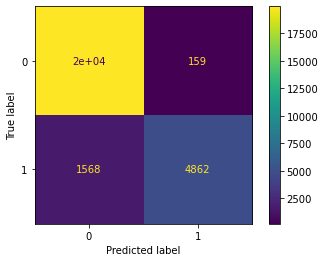

In [12]:
# fill with the best parameters found
# RUN THIS


xg_reg = xgb.XGBClassifier(objective ='binary:logistic', colsample_bytree = 0.95, colsample_bylevel = 0.95, eta = 0.15, gamma = 0.35, max_depth = 40, n_estimators = 200, reg_alpha = 0.15, reg_lambda = 0.15, min_child_weight = 10, scale_pos_weight = 0.72)


xgb_cl.fit(X_train, y_train)

# Predict
resultXGB = xgb_cl.predict(X_test)

# Score
#accuracy_score(y_test, preds)
print("Accuracy for XGBoost: " + str(accuracy_score(resultXGB, y_test)))
print("F1_Score for XGBoost: " + str(f1_score(resultXGB, y_test)))
print("Precision_Score for XGBoost: " + str(precision_score(resultXGB, y_test)))
print("Recall_Score for XGBoost: " + str(recall_score(resultXGB, y_test)))

cm = confusion_matrix(y_test, resultXGB)
%matplotlib inline
cm_display = ConfusionMatrixDisplay(cm).plot()